In [4]:


import torch





import matplotlib.pyplot as plt
from PIL import Image





#ab diffusion related imports
from AB_diffusion.user_hints import RandomHintGenerator, get_color_hints 
from AB_diffusion.color_handling import de_normalize_lab, normalize_lab,plotMinMax
from AB_diffusion.ab_denoising_diffusion_pytorch import ABUnet, ABGaussianDiffusion
from AB_diffusion.ab_trainer import ABDataset
from IPython.utils import io as iol
from skimage import io
from kornia.color import rgb_to_lab, lab_to_rgb
from datasets import load_from_disk,load_dataset
#from ab_classifier_free_guidance import *


import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import random
import glob
import mplcursors
import ipywidgets as widgets
from IPython.display import display
import torchvision.transforms as transforms

import plotly.express as px
import pandas as pd

In [5]:
device = torch.device(0 if torch.cuda.is_available() else "cpu")
print("Selected GPU:", torch.cuda.get_device_name(device))
#check wicj gpu is selected
torch.cuda.set_device(device)


Selected GPU: NVIDIA GeForce MX150


In [6]:


# Prepare the data
data_cosine = pd.DataFrame({
    'sqrt_alphas_cumprod': diffusion_model_cosine.sqrt_alphas_cumprod,
    'sqrt_one_minus_alphas_cumprod': diffusion_model_cosine.sqrt_one_minus_alphas_cumprod,
    "betas": diffusion_model_cosine.betas,
    "posterior_variance":  diffusion_model_cosine.posterior_variance,
    "posterior_mean_coef1": diffusion_model_cosine.posterior_mean_coef1,
    "loss_weights": diffusion_model_cosine.loss_weight
})
data_cosine.index = np.arange(0,1000,1)
data_sigmoid = pd.DataFrame({
    'sqrt_alphas_cumprod': diffusion_model_sig.sqrt_alphas_cumprod,
    'sqrt_one_minus_alphas_cumprod': diffusion_model_sig.sqrt_one_minus_alphas_cumprod,
    "betas": diffusion_model_sig.betas,
    "posterior_variance": diffusion_model_sig.posterior_variance,
    "posterior_mean_coef1": diffusion_model_sig.posterior_mean_coef1,
    "loss_weights": diffusion_model_sig.loss_weight
})
data_sigmoid.index = np.arange(0,1000,1)

data_linear = pd.DataFrame({
    'sqrt_alphas_cumprod': diffusion_model_linear.sqrt_alphas_cumprod,  
    'sqrt_one_minus_alphas_cumprod': diffusion_model_linear.sqrt_one_minus_alphas_cumprod,
    "betas": diffusion_model_linear.betas,
    "posterior_variance": diffusion_model_linear.posterior_variance,
    "posterior_mean_coef1": diffusion_model_linear.posterior_mean_coef1,
    "loss_weights": diffusion_model_linear.loss_weight
})
data_linear.index = np.arange(0,1000,1)

# Create a line plot
fig = px.line(data_cosine, x=data_cosine.index,y = data_cosine.loss_weights, title='Cosine Beta Schedule')
fig.show()

fig = px.line(data_sigmoid, x=data_sigmoid.index,y = data_sigmoid.loss_weights, title='Sigmoid Beta Schedule')
fig.show()

fig = px.line(data_linear, x=data_linear.index,y = data_linear.loss_weights, title='Linear Beta Schedule')
fig.show()


NameError: name 'diffusion_model_cosine' is not defined

In [19]:
x_t = np.random.randn(10000)

alphas =1- diffusion_model_sig.betas
betas = diffusion_model_sig.betas
sqrt_one_minus_alphas_cumprod = diffusion_model_sig.sqrt_one_minus_alphas_cumprod
alphas_cumprod = diffusion_model_sig.alphas_cumprod
alphas_cumprod_prev = diffusion_model_sig.alphas_cumprod_prev
posterior_log_variance_clipped = diffusion_model_sig.posterior_log_variance_clipped
x_t = torch.randn(10000)

for t in torch.arange(T-1, -1, -1):
    noise_pred = torch.randn(10000) # THIS IS A SURROGATE FOR A NEURAL NETWORK THAT PREDICTS THE NOISE ADDED TO DATA
    posterior_mean = 1 / torch.sqrt(alphas[t]) * (x_t - betas[t] / sqrt_one_minus_alphas_cumprod[t] * noise_pred)
    posterior_variance = betas[t] * (1. - alphas_cumprod_prev[t]) / (1. - alphas_cumprod[t])
    x_t = posterior_mean + (0.5 * posterior_log_variance_clipped[t]).exp() * torch.randn(10000)

print('standard deviation of', torch.std(x_t))

standard deviation of tensor(2599.8086)


In [23]:

def sigmoid_beta_schedule(timesteps, start = -3, end = 3, tau = 1, clamp_min = 1e-5):
    """
    sigmoid schedule
    proposed in https://arxiv.org/abs/2212.11972 - Figure 8
    better for images > 64x64, when used during training
    """
    steps = timesteps + 1
    t = torch.linspace(0, timesteps, steps, dtype = torch.float64) / timesteps
    v_start = torch.tensor(start / tau).sigmoid()
    v_end = torch.tensor(end / tau).sigmoid()
    alphas_cumprod = (-((t * (end - start) + start) / tau).sigmoid() + v_end) / (v_end - v_start)
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)


In [28]:
import numpy as np

betas = sigmoid_beta_schedule(1000)
alphas = 1. - betas
alphas_cumprod = np.cumprod(alphas)
alphas_cumprod_prev = np.hstack([1., alphas_cumprod[:-1]])
sqrt_one_minus_alphas_cumprod = np.sqrt(1. - alphas_cumprod)
sqrt_alphas_cumprod = np.sqrt(alphas_cumprod)
posterior_variance = np.clip(betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod), a_min = 1e-20, a_max = 1)


def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))
    
def sample_v( x_start, t, noise):
        return (
            extract(sqrt_alphas_cumprod, t, x_start.shape) * noise -
            extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape) * x_start
        )


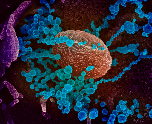

In [29]:
#load 46.jpg 
from PIL import Image
from kornia.color import rgb_to_lab
from torchvision import transforms

img = Image.open('46.jpg')
#convert to torch tensor
img = transforms.ToTensor()(img)
img = transforms.Resize((124))(img)

imgLAB = rgb_to_lab(img)
imgL, imgAB = imgLAB[:1, :, :], imgLAB[1:, :, :]
imgL = imgL / 50.0 - 1.0
imgAB = (imgAB / 128.0)




#cat them together, convert to rgb and display

imgLAB = torch.cat((imgL,imgAB),dim=0)
imgRGB = transforms.ToPILImage()(
            lab_to_rgb(
                de_normalize_lab(imgLAB.unsqueeze(0)).squeeze(0).detach().cpu()
            )
        )


imgRGB

In [36]:
import torchvision.utils as utils
n = 10
imgLAB_repeated = imgLAB.repeat(n,1,1,1)
t = torch.linspace(0, 999, n).long()
noise = torch.randn_like(imgLAB_repeated)

v = sample_v(imgLAB_repeated,t,noise)

v_noised_rgb_simoid = lab_to_rgb(
                de_normalize_lab(v).squeeze(0).detach().cpu()
            )
print(v_noised_rgb_simoid.shape)


v_noised_rgb_grid_sigmoid = transforms.ToPILImage() (utils.make_grid(v_noised_rgb_simoid, nrow=5))

torch.Size([10, 3, 124, 152])


In [38]:
def print_stats_for_each_image(images):
    batch_size = images.shape[0]
    for i in range(batch_size):
        mean = images[i].mean()
        std = images[i].std()
        print(f"Image {i+1}: Mean = {mean.item()}, StdDev = {std.item()}")

# Call the function
print_stats_for_each_image(v)

Image 1: Mean = -0.0006948769852321996, StdDev = 0.9963111553869655
Image 2: Mean = 0.04422513409499054, StdDev = 0.9777925672943084
Image 3: Mean = 0.06401248790150375, StdDev = 0.9439596656283894
Image 4: Mean = 0.09097711461192623, StdDev = 0.8896943183558552
Image 5: Mean = 0.11538743161230745, StdDev = 0.8102170414570529
Image 6: Mean = 0.14700997025508244, StdDev = 0.7024629068430622
Image 7: Mean = 0.16026733395816029, StdDev = 0.5966719568337276
Image 8: Mean = 0.17360800147559305, StdDev = 0.4988335753473079
Image 9: Mean = 0.18139132516217535, StdDev = 0.42788105493517287
Image 10: Mean = 0.18559181147971554, StdDev = 0.3803785373173753


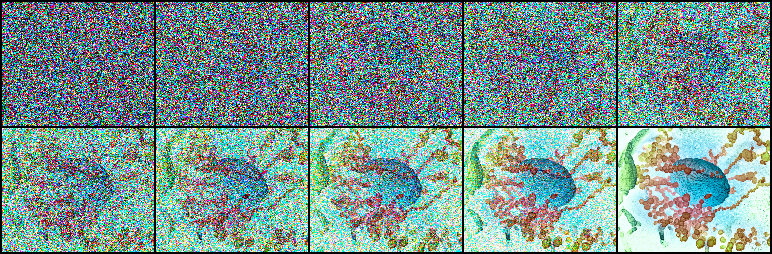

In [39]:
v_noised_rgb_grid_sigmoid

In [45]:
# sample noised imakes from t 0 to 1000, in n steps
n = 20
#repeat img lab n times
imgLAB_repeated = imgLAB.repeat(n,1,1,1)
t = torch.linspace(0, 999, n).long()
img_noised_cosine = diffusion_model_cosine.q_sample(imgLAB_repeated, t)

img_noised_rgb_cosine = lab_to_rgb(
                de_normalize(img_noised_cosine).squeeze(0).detach().cpu()
            )

#show the noised images in a grid
img_noised_rgb_grid_cosine = transforms.ToPILImage() (utils.make_grid(img_noised_rgb_cosine, nrow=5))

img_noised_sigmoid = diffusion_model_sig.q_sample(imgLAB_repeated, t)
img_noised_rgb_sigmoid = lab_to_rgb(
                de_normalize(img_noised_sigmoid).squeeze(0).detach().cpu()
            )
img_noised_rgb_grid_sigmoid = transforms.ToPILImage() (utils.make_grid(img_noised_rgb_sigmoid, nrow=5))

In [46]:
def print_stats_for_each_image(images):
    batch_size = images.shape[0]
    for i in range(batch_size):
        mean = images[i].mean()
        std = images[i].std()
        print(f"Image {i+1}: Mean = {mean.item()}, StdDev = {std.item()}")

# Call the function
print_stats_for_each_image(img_noised_cosine)

Image 1: Mean = -0.2010999321937561, StdDev = 0.34014415740966797
Image 2: Mean = -0.20017658174037933, StdDev = 0.351342111825943
Image 3: Mean = -0.19807954132556915, StdDev = 0.37841707468032837
Image 4: Mean = -0.19349950551986694, StdDev = 0.41659149527549744
Image 5: Mean = -0.18977712094783783, StdDev = 0.4634496867656708
Image 6: Mean = -0.18264828622341156, StdDev = 0.5146005749702454
Image 7: Mean = -0.1755470633506775, StdDev = 0.5676594376564026
Image 8: Mean = -0.16678720712661743, StdDev = 0.6234980821609497
Image 9: Mean = -0.156847283244133, StdDev = 0.6750932335853577
Image 10: Mean = -0.14986151456832886, StdDev = 0.726640522480011
Image 11: Mean = -0.1343507021665573, StdDev = 0.7728087902069092
Image 12: Mean = -0.12153840065002441, StdDev = 0.8194419145584106
Image 13: Mean = -0.10971400141716003, StdDev = 0.8583648204803467
Image 14: Mean = -0.09888500720262527, StdDev = 0.8967377543449402
Image 15: Mean = -0.07763028889894485, StdDev = 0.9268308281898499
Image 16

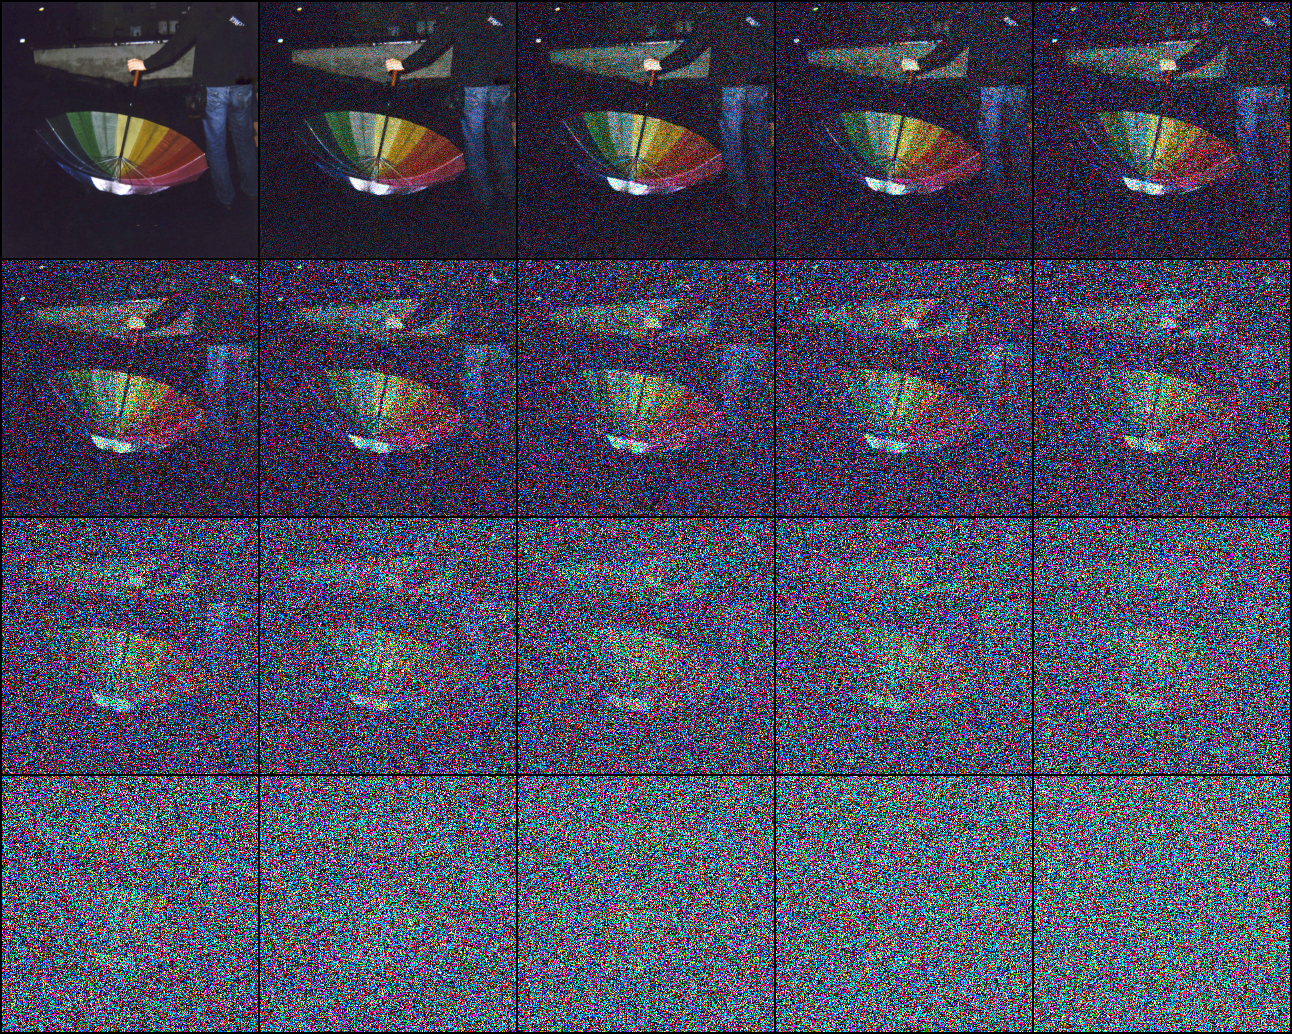

In [47]:
img_noised_rgb_grid_cosine

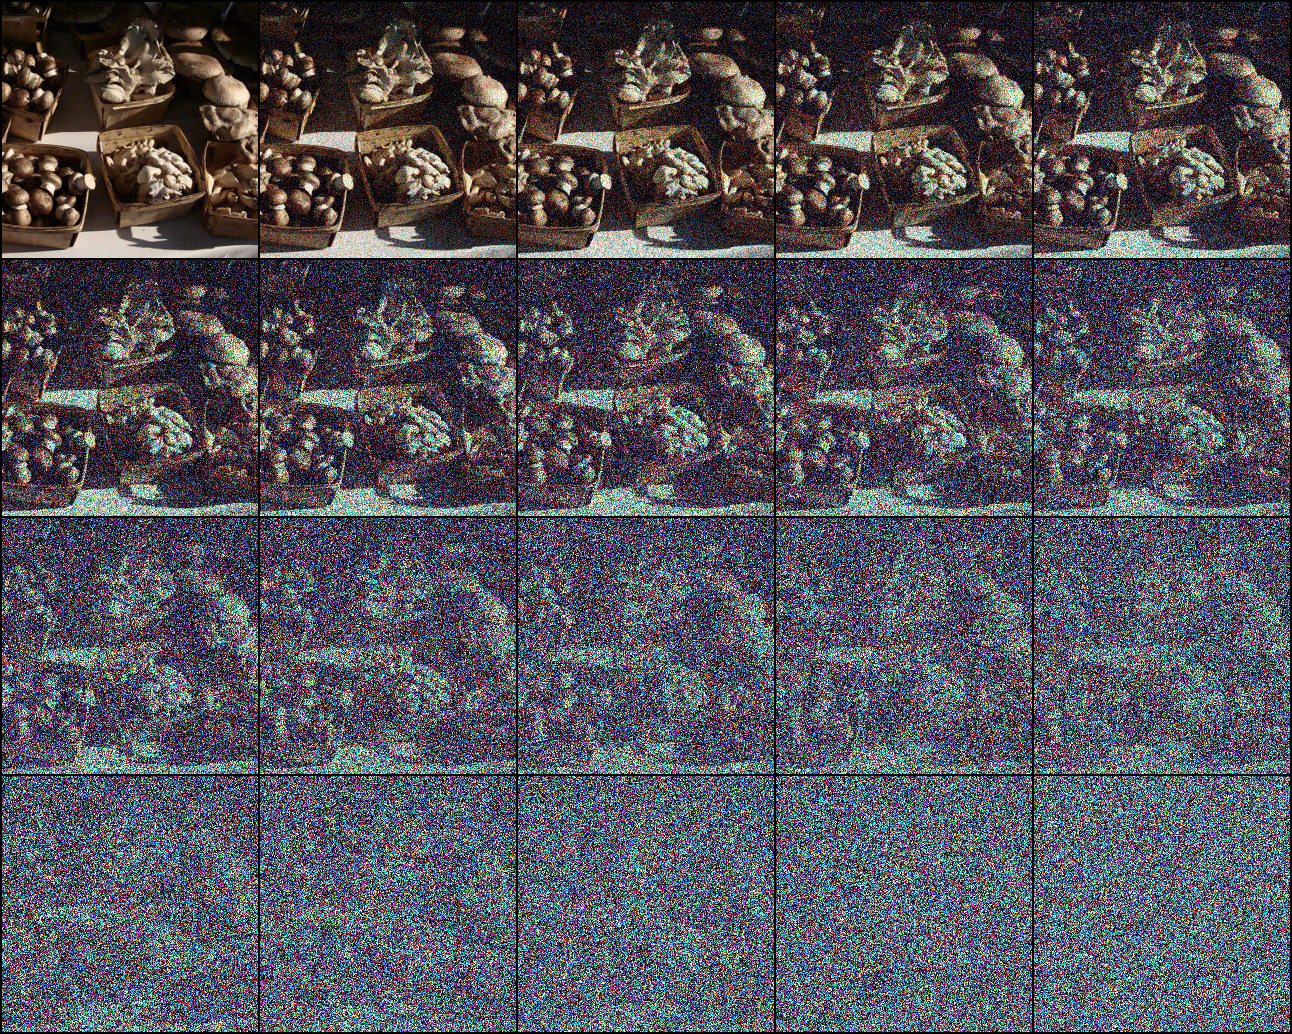

In [40]:
img_noised_rgb_grid_sigmoid